# Exploratory Data Analysis
## Introduction
After cleaning the data it is important to examine the data to see if it makes sense.

## Input
1. The clean corpus generated by the data_cleaning notebook
2. The dtm (document term matrix) generated by the data_cleaning notebook


## Output
1. Percentage of Species Reviewed
2. A list of the most common words with their frequencies
3. Word Cloud
4. A new dtm with additional stop words removed
5. Distribution of Unique Word Counts in Reviews

In [1]:
import os
from os.path import exists
import json
import spacy
from spacy import displacy
import pandas as pd
import itertools as it
import tqdm as notebook_tqdm
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models
import warnings
import pickle
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from spacy.util import minibatch
from bokeh.plotting import figure, output_notebook, show
import numpy as np
import nltk
from collections import Counter
import string
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/home/moogedelic/anaconda3/envs/nlp_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
parent_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=data_sets/strains'
strain_data_dir = parent_dir+'/strain_data'
temp_dir = parent_dir+'/temp'
image_dir = parent_dir+'/image'
if not exists(image_dir):
    os.mkdir(image_dir)

## There Are Reviews for 156 Strains

In [3]:
# Read in cleaned corpus
data_clean = pd.read_parquet(temp_dir+'/corpus.parquet')
data_clean

,species,report,tri_review
strain,,,
1024,Sativa,it a good even head and body high good for str...,good head body high good stress nice high good...
24k-gold,Hybrid,you can change the name give it no name call i...,change schnauzerganjkosher tangie k gold gold ...
3-kings,Hybrid,I be skeptical about this strain after try thr...,skeptical_about strain try kings amazed reliev...
3x-crazy,Indica,this strain be always a favorite the top favor...,strain favorite favorite fact potency strain d...
501st-og,Hybrid,I have m and this strain be suggest for I to h...,m strain suggest help muscle_spasm occur m sle...
...,...,...,...
yoda-og,Indica,superdank I finally find my medicine I can nt ...,superdank finally_find medicine nt sleep activ...
yogi-diesel,Hybrid,this strain provide a nice head high where you...,strain provide nice head high thought forefron...
yumboldt,Indica,this strain be excellent for relieve my migrai...,strain excellent relieve migraine chance strai...


In [4]:
df = data_clean.species.value_counts().rename_axis('species').reset_index(name='counts')
df['percentage'] = df.counts / len(data_clean) * 100
df

,species,counts,percentage
0,Hybrid,533,50.473485
1,Indica,320,30.30303
2,Sativa,203,19.223485


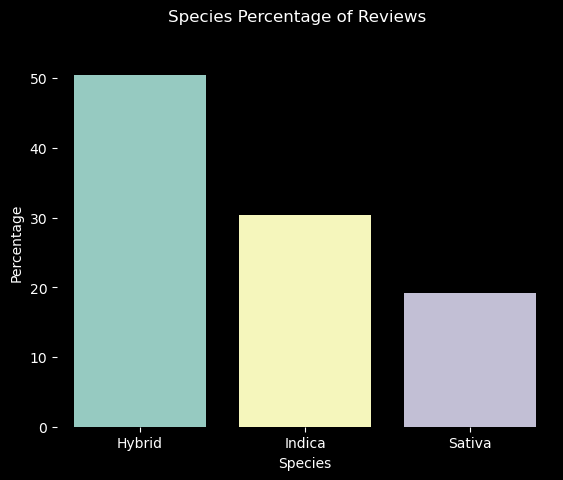

In [5]:
plt.style.use('dark_background')
bar = sns.barplot(df, x = 'species', y = 'percentage');
sns.despine(top=True, right=True, left=True, bottom=True);
bar.set(xlabel='Species', ylabel='Percentage');
fig = bar.get_figure();
fig.suptitle('Species Percentage of Reviews');
fig.savefig(image_dir+'/species_percentage.png');

## Term Document Matrix

In [6]:
# Read in the document term matrix
data = pd.read_parquet(temp_dir+'/dtm.parquet')
# Transpose the DTM to create a Term Document Matrix
data = data.transpose()
data.head(25)

strain,1024,24k-gold,3-kings,3x-crazy,501st-og,5th-element,707-headband,8-ball-kush,818-og,91-krypt,...,wookies,wsu,xxx-og,y-griega,yeti-og,yoda-og,yogi-diesel,yumboldt,yummy,zeus-og
_all,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aa,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaaaaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaaaaaqaaaaaaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaahhhhhhmaxing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaahhhhhhh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Find The Top 30 Words For Each Strain
Many of the reviews have less than 30 words; take that into consideration when interpreting the results

In [7]:
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

## Look at the most common top words and add them to the stop word list

In [8]:
# First pull out the top 30 words for each strain
words = []
for strain in data.columns:
    top = [word for (word, count) in top_dict[strain]]
    for t in top:
        words.append(t)

## Aggregate this list and identify the most common words along with how many reviews they occur in

In [9]:
Counter(words).most_common()

[('strain', 1021),
 ('high', 974),
 ('good', 954),
 ('great', 939),
 ('smoke', 909),
 ('taste', 893),
 ('like', 890),
 ('feel', 838),
 ('nice', 809),
 ('smell', 789),
 ('do_nt', 606),
 ('love', 600),
 ('bud', 559),
 ('body', 536),
 ('effect', 502),
 ('definitely', 483),
 ('day', 483),
 ('try', 468),
 ('hit', 461),
 ('pain', 459),
 ('strong', 446),
 ('time', 446),
 ('head', 429),
 ('indica', 374),
 ('happy', 319),
 ('flavor', 304),
 ('amazing', 302),
 ('anxiety', 301),
 ('if_you', 300),
 ('sweet', 290),
 ('relax', 278),
 ('sativa', 270),
 ('favorite', 262),
 ('sleep', 259),
 ('relaxed', 256),
 ('help', 251),
 ('smooth', 234),
 ('look', 215),
 ('pretty', 188),
 ('little', 183),
 ('hybrid', 162),
 ('use', 156),
 ('find', 154),
 ('relaxing', 153),
 ('super', 152),
 ('work', 150),
 ('want', 147),
 ('heavy', 145),
 ('uplifting', 129),
 ('stuff', 120),
 ('flower', 113),
 ('grow', 108),
 ('perfect', 107),
 ('weed', 106),
 ('mellow', 102),
 ('enjoy', 96),
 ('think', 93),
 ('buzz', 93),
 ('amp',

## If more than half of the strain reviews contain a word add it to the stop list
Add other words top in the top half that don't apply to cannabis (if_you ...)

In [10]:
custom_stop_words = set(['strain', 'high', 'good', 'great', 'smoke', 'taste', 'like', 'feel', 'nice', 'smell', 'do_nt', 'love', 'bud', 'body', 'definitely', 'day', 'try','hit','if_you', 'want', 'do_nt', 'if_you', 'so_far', 'i_m', 'nt', 've', 'i_ve'])

In [11]:
STOPWORDS.update(list(custom_stop_words))
print(STOPWORDS)

{"weren't", 'some', 'too', 'after', 'else', "you've", 'as', "i've", 'we', 'have', 'body', 'hers', "isn't", 'having', 'then', 'your', "you'd", 'other', 'ourselves', 'against', "shan't", "there's", 'up', "he'd", 'while', "hadn't", 've', 'want', 'during', 'feel', 'her', 'great', 'because', 'when', 'our', 'nt', 'theirs', 'him', "couldn't", 'so', 'themselves', 'these', 'smoke', 'an', 'do_nt', 'where', 'myself', "we'd", 'day', 'to', 'a', 'below', 'before', 'you', 'i_ve', 'again', "that's", "won't", 'cannot', 'try', 'shall', 'nice', 'they', 'until', 'whom', 'all', 'its', 'than', 'good', 'strain', 'been', 'no', 'in', "it's", 'http', 'but', "i'll", "mustn't", 'from', 'could', 'yourselves', 'therefore', "who's", 'definitely', 'yourself', 'and', 'ought', 'their', 'his', "how's", "you'll", 'himself', 'who', "wouldn't", 'is', 'should', 'would', 'love', "aren't", 'yours', 'can', 'am', 'not', 'own', 'high', 'otherwise', "they've", "we're", 'only', 'www', 'more', "didn't", 'if', 'was', 'get', 'i', 'r'

## Word Cloud

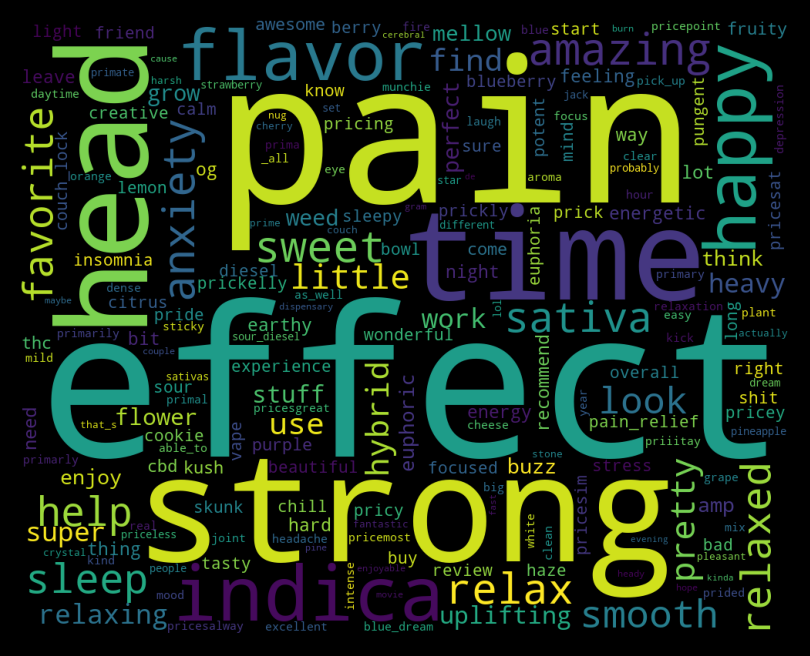

In [12]:
width = 1000
height = 800
# Remove the new stop words from the most common words
word_freq = dict(Counter(words).most_common())
most_common_words = {word: word_freq[word] for word in word_freq if word not in list(STOPWORDS)}
# Create the word cloud
wordcloud = WordCloud(width = width, height = height,
                      min_font_size = 10,
                      collocations=False,).generate_from_frequencies(most_common_words)
my_dpi=200
plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
plt.imshow(wordcloud);
plt.axis("off");
plt.savefig(image_dir+'/word_cloud.png', dpi=my_dpi);

## Remove the new stop words from the corpus

In [13]:
cls = spacy.util.get_lang_class('en')
cls.Defaults.stop_words = custom_stop_words

!python -m spacy download en_core_web_trf
nlp = spacy.load('en_core_web_trf')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.3/460.3 MB 4.4 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [14]:
def remove_stop_words(x):
    doc = nlp(x)
    stopless_list = []
    for token in doc:
        if not token.is_stop:
            stopless_list.append(token.text)
            
    return " ".join(stopless_list)

In [15]:
# Remove new stop words from the corpus
data_clean.tri_review = data_clean.tri_review.apply(lambda x: remove_stop_words(x))

# Recreate document-term matrix with the new stop words removed

In [16]:
cv = CountVectorizer()
data_cv = cv.fit_transform(data_clean.tri_review)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_stop.index = data_clean.index

# Save for later use
pickle.dump(cv, open(temp_dir+"/cv_stop.pkl", "wb"))
data_stop.to_parquet(temp_dir+"/dtm_stop.parquet")

In [17]:
data_clean

,species,report,tri_review
strain,,,
1024,Sativa,it a good even head and body high good for str...,head stress result come flower bong grind_up b...
24k-gold,Hybrid,you can change the name give it no name call i...,change schnauzerganjkosher tangie k gold gold ...
3-kings,Hybrid,I be skeptical about this strain after try thr...,skeptical_about kings amazed relieve stress in...
3x-crazy,Indica,this strain be always a favorite the top favor...,favorite favorite fact potency dependent growe...
501st-og,Hybrid,I have m and this strain be suggest for I to h...,m suggest help muscle_spasm occur m sleepingth...
...,...,...,...
yoda-og,Indica,superdank I finally find my medicine I can nt ...,superdank finally_find medicine sleep active i...
yogi-diesel,Hybrid,this strain provide a nice head high where you...,provide head thought forefront provide channel...
yumboldt,Indica,this strain be excellent for relieve my migrai...,excellent relieve migraine chance amp atleast ...


In [18]:
data_stop

,_all,aa,aaa,aaaa,aaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaqaaaaaaaa,aaaaaaaaaand,aaaaaahhhhhhmaxing,aaaahhhhhhh,...,zzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,ıf,łēčtrpart,ʻohana,ʻono,δthc,⅛th,⅛thweight
strain,,,,,,,,,,,,,,,,,,,,,
1024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24k-gold,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-kings,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3x-crazy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501st-og,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yoda-og,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yogi-diesel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yumboldt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## The Number of Unique Words by Strain Review

In [19]:
unique_list = []
for strain in data.columns:
    uniques = data[strain].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(data.columns, unique_list)), columns=['strain', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,strain,unique_words
702,pink-pez,2
971,trash,3
209,cheeseburger,3
284,dank-sinatra,4
796,sapphire-scout,5
...,...,...
103,blackberry-kush,3091
229,cherry-pie,3295
908,super-lemon-haze,3770
428,harlequin,3819


## Distribution of Unique Words in Strain Reviews

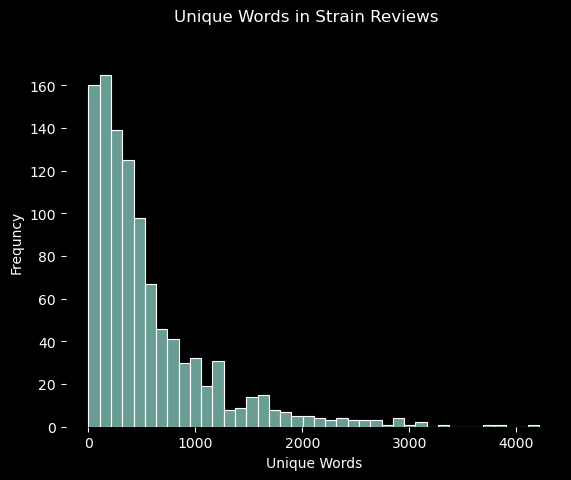

In [27]:
hist = sns.histplot(data = data_words, x = 'unique_words');
sns.despine(top=True, right=True, left=True, bottom=True);
hist.set(xlabel='Unique Words', ylabel='Frequncy');
fig = hist.get_figure();
fig.suptitle('Unique Words in Strain Reviews');
fig.savefig(image_dir+'/unique_wordspng');